In [88]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import os
import zipfile
import numpy as np
import pandas as pd
from io import StringIO
pd.set_option("display.max_columns", None)

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer

from tensorflow.keras import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras import losses, optimizers, activations, regularizers, callbacks

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
working_dir = os.getcwd()
working_dir

'/content'

In [3]:
def Extract_Data(working_dir):
    for i in os.listdir(working_dir):
        if i.endswith(".zip"):
            zip_path = os.path.join(working_dir, i)
            with zipfile.ZipFile(zip_path) as extractor:
                extractor.extractall(working_dir)

def Load_Data(working_dir):
    for i in os.listdir(working_dir):
        if os.path.isfile(i) and (".csv" in i):
            data = pd.read_csv(i)
    return data

In [4]:
df = Load_Data(Extract_Data(working_dir))

print(df.shape)

df.head()

(142193, 24)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [5]:
df.dropna(axis=0, thresh=24, inplace=True)

In [6]:
df.columns = [i.lower() for i in df.columns]

df.columns

Index(['date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation',
       'sunshine', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm',
       'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm',
       'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am',
       'temp3pm', 'raintoday', 'risk_mm', 'raintomorrow'],
      dtype='object')

In [7]:
df.isnull().sum() / df.shape[0] * 100

date             0.0
location         0.0
mintemp          0.0
maxtemp          0.0
rainfall         0.0
evaporation      0.0
sunshine         0.0
windgustdir      0.0
windgustspeed    0.0
winddir9am       0.0
winddir3pm       0.0
windspeed9am     0.0
windspeed3pm     0.0
humidity9am      0.0
humidity3pm      0.0
pressure9am      0.0
pressure3pm      0.0
cloud9am         0.0
cloud3pm         0.0
temp9am          0.0
temp3pm          0.0
raintoday        0.0
risk_mm          0.0
raintomorrow     0.0
dtype: float64

In [8]:
display_info = StringIO()
df.info(buf=display_info)
print(display_info.getvalue())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 5939 to 139112
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           56420 non-null  object 
 1   location       56420 non-null  object 
 2   mintemp        56420 non-null  float64
 3   maxtemp        56420 non-null  float64
 4   rainfall       56420 non-null  float64
 5   evaporation    56420 non-null  float64
 6   sunshine       56420 non-null  float64
 7   windgustdir    56420 non-null  object 
 8   windgustspeed  56420 non-null  float64
 9   winddir9am     56420 non-null  object 
 10  winddir3pm     56420 non-null  object 
 11  windspeed9am   56420 non-null  float64
 12  windspeed3pm   56420 non-null  float64
 13  humidity9am    56420 non-null  float64
 14  humidity3pm    56420 non-null  float64
 15  pressure9am    56420 non-null  float64
 16  pressure3pm    56420 non-null  float64
 17  cloud9am       56420 non-null  float64
 18  cl

In [9]:
df.nunique()

date             3416
location           26
mintemp           348
maxtemp           395
rainfall          410
evaporation       259
sunshine          145
windgustdir        16
windgustspeed      61
winddir9am         16
winddir3pm         16
windspeed9am       36
windspeed3pm       37
humidity9am       101
humidity3pm       101
pressure9am       504
pressure3pm       507
cloud9am            9
cloud3pm           10
temp9am           383
temp3pm           393
raintoday           2
risk_mm           498
raintomorrow        2
dtype: int64

In [10]:
df.describe().style.background_gradient(cmap="coolwarm")

,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,risk_mm
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333,2.346960
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543,8.731885
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000,0.000000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000,0.000000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000,0.000000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000,0.600000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000,367.600000


In [11]:
df["date"] = pd.to_datetime(df["date"])

In [12]:
numeric_data = df.select_dtypes(exclude="O")
categorical_data = df.select_dtypes(include="O")

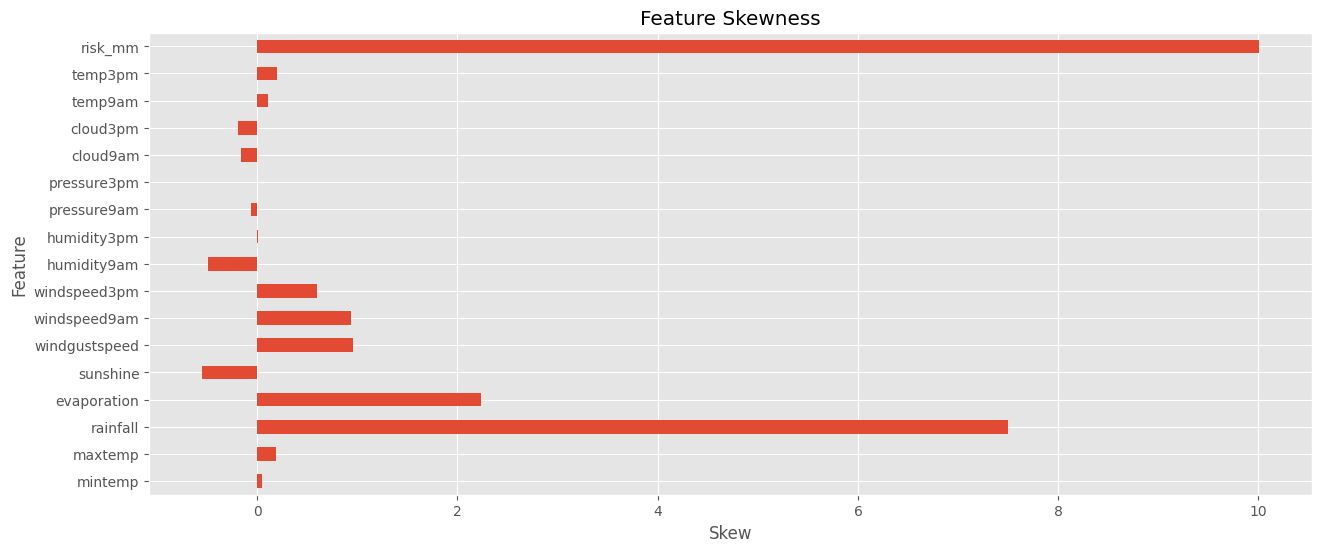

In [13]:
numeric_data.drop("date", axis=1).skew().plot(kind="barh",
                                              figsize=(15, 6),
                                              xlabel="Skew",
                                              ylabel="Feature",
                                              title="Feature Skewness")

plt.show()

In [14]:
df.reset_index(drop=True, inplace=True)

In [15]:
for col in df.select_dtypes(include="O").columns:
  df[col] = LabelEncoder().fit_transform(df[col])

In [16]:
df["day"] = df["date"].dt.day
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

df.drop("date", axis=1, inplace=True)

In [17]:
X = df.drop("raintomorrow", axis=1).apply(stats.zscore)
y = df["raintomorrow"]

In [18]:
X.head()

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,risk_mm,day,year,month
0,-1.181844,0.691208,1.575298,-0.303702,1.757691,1.214537,0.733362,0.534126,-1.313714,0.939282,-1.162355,0.025055,-2.477924,-1.812261,-1.583303,-1.513002,-0.801428,0.254411,1.278186,1.563621,-0.532445,-0.268783,-1.676515,-1.314211,-1.57185
1,-1.181844,0.769131,0.671504,-0.303702,2.515216,1.400800,0.107353,-0.290764,0.617292,0.514803,0.400721,-0.092452,-1.937767,-2.059824,-0.628068,-0.392322,-1.158937,-1.256603,0.318980,0.627467,-0.532445,-0.268783,-1.562652,-1.314211,-1.57185
2,-1.181844,0.924976,1.919600,-0.303702,1.433038,0.762183,-0.518656,0.384146,-0.455489,-0.334155,1.723325,-0.562482,-1.289578,-1.366647,-0.714907,-0.814396,-1.158937,0.632165,1.597921,1.783032,-0.532445,-0.268783,-1.334925,-1.314211,-1.57185
3,-1.181844,1.314588,2.034368,-0.303702,1.595364,1.187928,1.359371,-0.740704,1.475517,1.576000,-1.162355,-1.620048,-1.559657,-1.366647,-0.657014,-0.828951,-1.158937,0.254411,1.658823,1.885424,-0.532445,-0.268783,-1.221061,-1.314211,-1.57185
4,-1.181844,1.673032,2.407362,-0.303702,1.541255,0.176784,1.359371,-0.440744,-0.026377,1.363761,0.160248,-0.797496,-2.531940,-1.713236,-0.946479,-1.076373,-1.158937,0.632165,2.343970,2.177972,-0.532445,-0.268783,-1.107198,-1.314211,-1.57185


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, stratify=y, random_state=0)

## Modelling

In [20]:
# Functional API

model_input = layers.Input(shape=(X.shape[1], ))
x = layers.Dense(units=128, activation="tanh", kernel_regularizer=regularizers.L1L2())(model_input)
x = layers.Dropout(rate=0.7)(x)
x = layers.Dense(units=64, activation="tanh", kernel_regularizer=regularizers.L1L2())(x)
x = layers.Dropout(rate=0.7)(x)
x = layers.Dense(units=32, activation="tanh", kernel_regularizer=regularizers.L1L2())(x)
x = layers.Dense(units=16, activation="tanh", kernel_regularizer=regularizers.L1L2())(x)
output = layers.Dense(units=1, activation="sigmoid")(x)
model_output = Model(inputs=model_input, outputs=output)

model_output.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense (Dense)               (None, 128)               3328      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528   

In [21]:
model_output.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), metrics=["accuracy"])

In [22]:
history_1 = model_output.fit(X_train, y_train,
                             validation_split=0.1,
                             callbacks=[callbacks.EarlyStopping(patience=10)],
                             batch_size=32,
                             epochs=100)

Epoch 1/100
1571/1571 [==============================] - 12s 6ms/step - loss: 0.2388 - accuracy: 0.9047 - val_loss: 0.0827 - val_accuracy: 0.9714
Epoch 2/100
1571/1571 [==============================] - 7s 4ms/step - loss: 0.0819 - accuracy: 0.9719 - val_loss: 0.0157 - val_accuracy: 0.9946
Epoch 3/100
1571/1571 [==============================] - 9s 6ms/step - loss: 0.0480 - accuracy: 0.9823 - val_loss: 0.0145 - val_accuracy: 0.9928
Epoch 4/100
1571/1571 [==============================] - 6s 4ms/step - loss: 0.0354 - accuracy: 0.9873 - val_loss: 0.0087 - val_accuracy: 0.9968
Epoch 5/100
1571/1571 [==============================] - 5s 3ms/step - loss: 0.0325 - accuracy: 0.9876 - val_loss: 0.0094 - val_accuracy: 0.9961
Epoch 6/100
1571/1571 [==============================] - 4s 2ms/step - loss: 0.0282 - accuracy: 0.9896 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 7/100
1571/1571 [==============================] - 4s 2ms/step - loss: 0.0262 - accuracy: 0.9897 - val_loss: 0.0098 - val_a

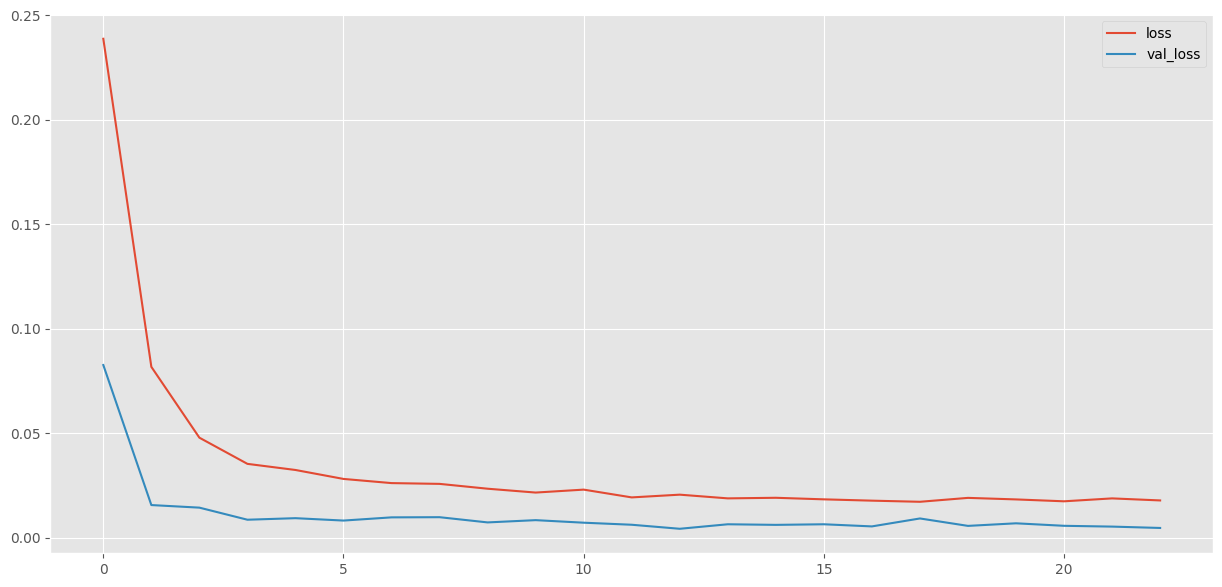

In [23]:
l_p = pd.DataFrame(history_1.history)[["loss", "val_loss"]].plot(figsize=(15, 7))

plt.show()

In [24]:
loss, acc_score = model_output.evaluate(X_test, y_test)

print(f"Loss: {loss}")
print(f"Accuracy score: {acc_score}")

18/18 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 0.9965
Loss: 0.008746122010052204
Accuracy score: 0.9964601993560791


In [25]:
print(classification_report(y_test, (model_output.predict(X_test) > 0.5).astype("int")))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441
           1       0.99      0.99      0.99       124

    accuracy                           1.00       565
   macro avg       0.99      0.99      0.99       565
weighted avg       1.00      1.00      1.00       565



In [32]:
def Plot_ROC_Curve(y_true, y_pred):
  fpr, tpr, treshold = roc_curve(y_true, y_pred)
  auc_score = auc(fpr, tpr)

  plt.figure(figsize=(15, 6))
  plt.plot(fpr, tpr, label=f"AUC_SCORE: {auc_score}")
  plt.plot([0, 1], [0, 1], ls="--")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC AUC CURVE")
  plt.legend()
  plt.show()

18/18 [==============================] - 0s 2ms/step


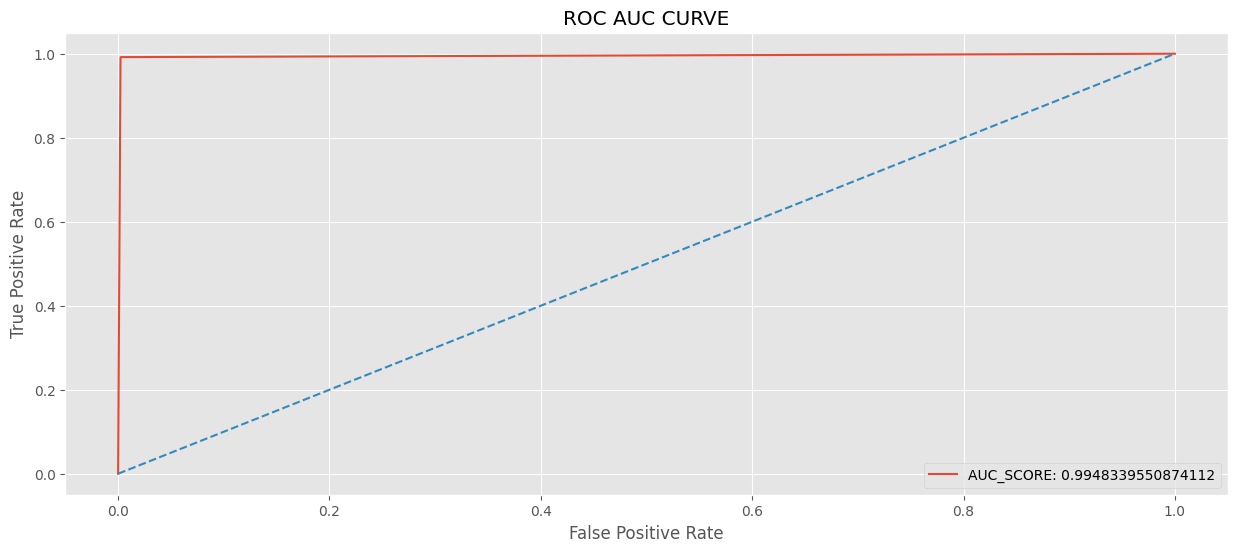

In [33]:
Plot_ROC_Curve(y_test, (model_output.predict(X_test) > 0.5).astype("int").flatten())

## KMEAN CLUSTERING

In [64]:
inertia = []
cluster_score = []
for i in range(2, 15):
  kmean = KMeans(n_clusters=i)
  cluster_score.append(silhouette_score(X, kmean.fit_predict(X)))
  inertia.append(kmean.inertia_)

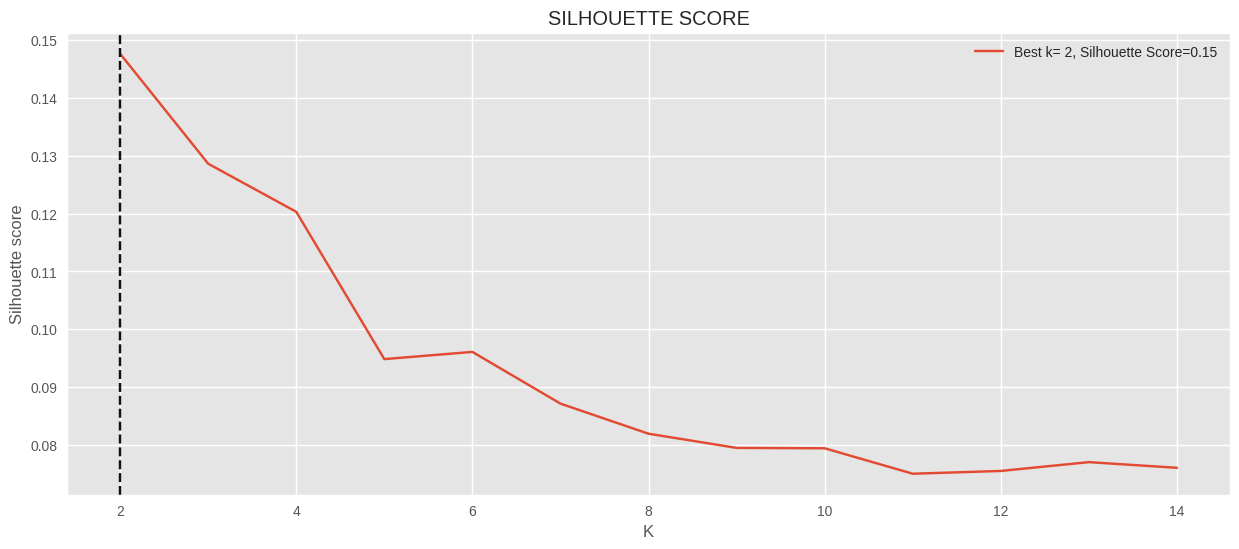

In [65]:
plt.figure(figsize=(15, 6))
plt.title("SILHOUETTE SCORE")
plt.plot(range(2, 15), cluster_score, label=f"Best k= {np.argmax(cluster_score)+2}, Silhouette Score={round(max(cluster_score), 2)}")
plt.axvline(np.argmax(cluster_score) + 2, ls="--", c="k")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

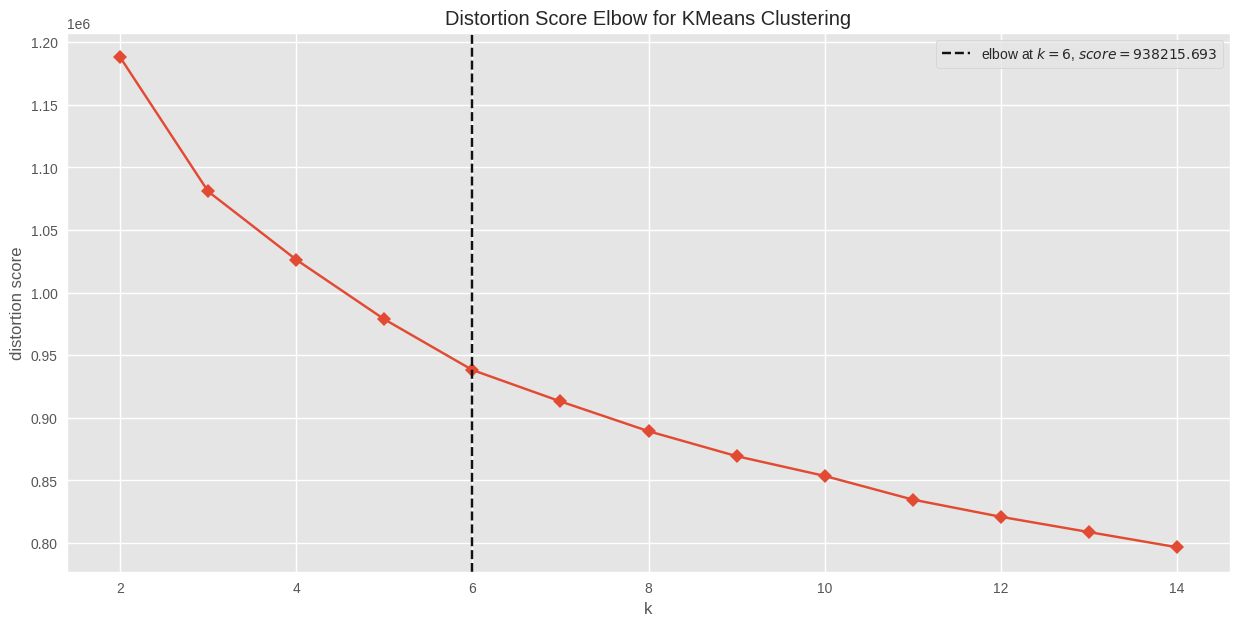

In [66]:
plt.figure(figsize=(15, 7))

visualizer = KElbowVisualizer(estimator=KMeans(), k=(2, 15), timings=False)

visualizer.fit(X)

visualizer.show()

plt.show()

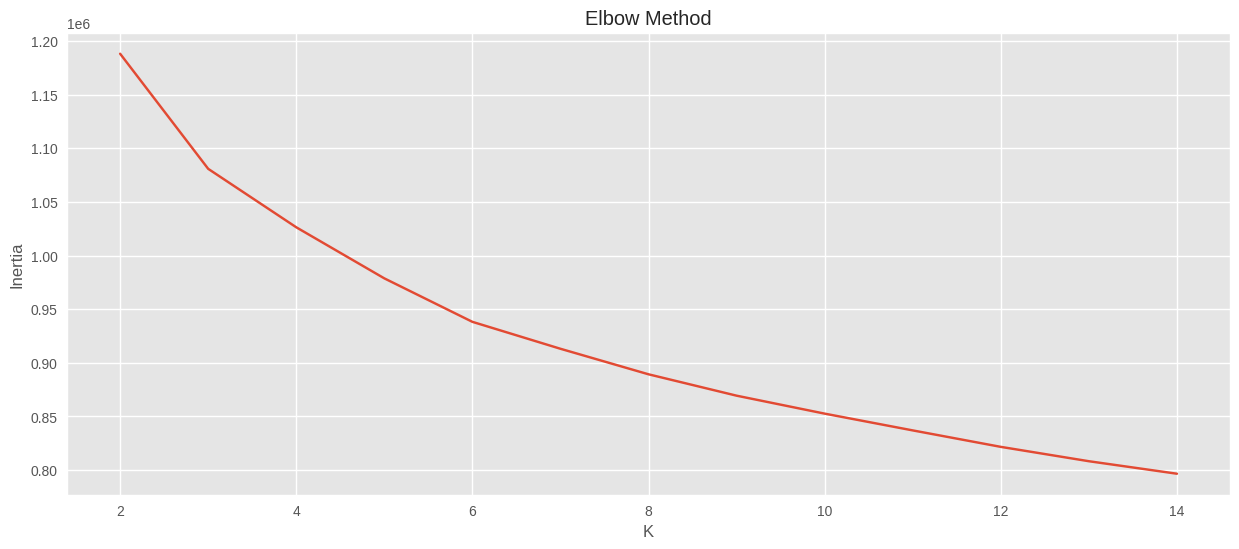

In [69]:
plt.figure(figsize=(15, 6))

plt.plot(range(2, 15), inertia)

plt.xlabel("K")

plt.ylabel("Inertia")

plt.title("Elbow Method")

plt.show()

In [70]:
cluster_data = X.copy()

kmean_best = KMeans(n_clusters=2)

cluster_data["cluster"] = kmean_best.fit_predict(cluster_data)

In [75]:
cluster_data["cluster"] = stats.zscore(cluster_data["cluster"])

In [78]:
# Functional API

model_input = layers.Input(shape=(cluster_data.shape[1], ))
x = layers.Dense(units=128, activation="tanh", kernel_regularizer=regularizers.L1L2())(model_input)
x = layers.Dropout(rate=0.7)(x)
x = layers.Dense(units=64, activation="tanh", kernel_regularizer=regularizers.L1L2())(x)
x = layers.Dropout(rate=0.7)(x)
x = layers.Dense(units=32, activation="tanh", kernel_regularizer=regularizers.L1L2())(x)
x = layers.Dense(units=16, activation="tanh", kernel_regularizer=regularizers.L1L2())(x)
output = layers.Dense(units=1, activation="sigmoid")(x)
model_output_2 = Model(inputs=model_input, outputs=output)

model_output_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_10 (Dense)            (None, 128)               3456      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528 

In [84]:
model_output_2.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [85]:
history_2 = model_output_2.fit(cluster_data, y,
                               validation_split=0.1,
                               callbacks=[callbacks.EarlyStopping(patience=10)],
                               batch_size=32,
                               epochs=100)

Epoch 1/100
1587/1587 [==============================] - 6s 3ms/step - loss: 0.2394 - accuracy: 0.9025 - val_loss: 0.0433 - val_accuracy: 0.9856
Epoch 2/100
1587/1587 [==============================] - 4s 2ms/step - loss: 0.0789 - accuracy: 0.9728 - val_loss: 0.0111 - val_accuracy: 0.9952
Epoch 3/100
1587/1587 [==============================] - 4s 2ms/step - loss: 0.0470 - accuracy: 0.9830 - val_loss: 0.0093 - val_accuracy: 0.9965
Epoch 4/100
1587/1587 [==============================] - 4s 3ms/step - loss: 0.0381 - accuracy: 0.9859 - val_loss: 0.0076 - val_accuracy: 0.9972
Epoch 5/100
1587/1587 [==============================] - 4s 3ms/step - loss: 0.0332 - accuracy: 0.9874 - val_loss: 0.0089 - val_accuracy: 0.9966
Epoch 6/100
1587/1587 [==============================] - 4s 2ms/step - loss: 0.0305 - accuracy: 0.9884 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 7/100
1587/1587 [==============================] - 4s 2ms/step - loss: 0.0264 - accuracy: 0.9901 - val_loss: 0.0071 - val_ac

In [112]:
def Plot_Decision_Boundary(df, n_clusters):
  kmean = KMeans(n_clusters=n_clusters)
  reduced_data = PCA(n_components=2).fit_transform(df)

  kmean.fit(reduced_data)

  x_min, x_max = reduced_data[:, 0].min()-1, reduced_data[:, 0].max()+1
  y_min, y_max = reduced_data[:, 1].min()-1, reduced_data[:, 1].max()+1

  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

  Z = kmean.predict(np.c_[xx.flatten(), yy.flatten()])
  Z = Z.reshape(xx.shape)

  plt.figure(figsize=(15, 7))
  plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], cmap=plt.cm.Paired, c=kmean.labels_, alpha=0.5, edgecolors="k")
  plt.scatter(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], cmap=plt.cm.Paired, marker="x", s=200, lw=2, color="k")
  plt.title(f"DECISION BOUNDARY, N_cluster={n_clusters}")
  plt.show()

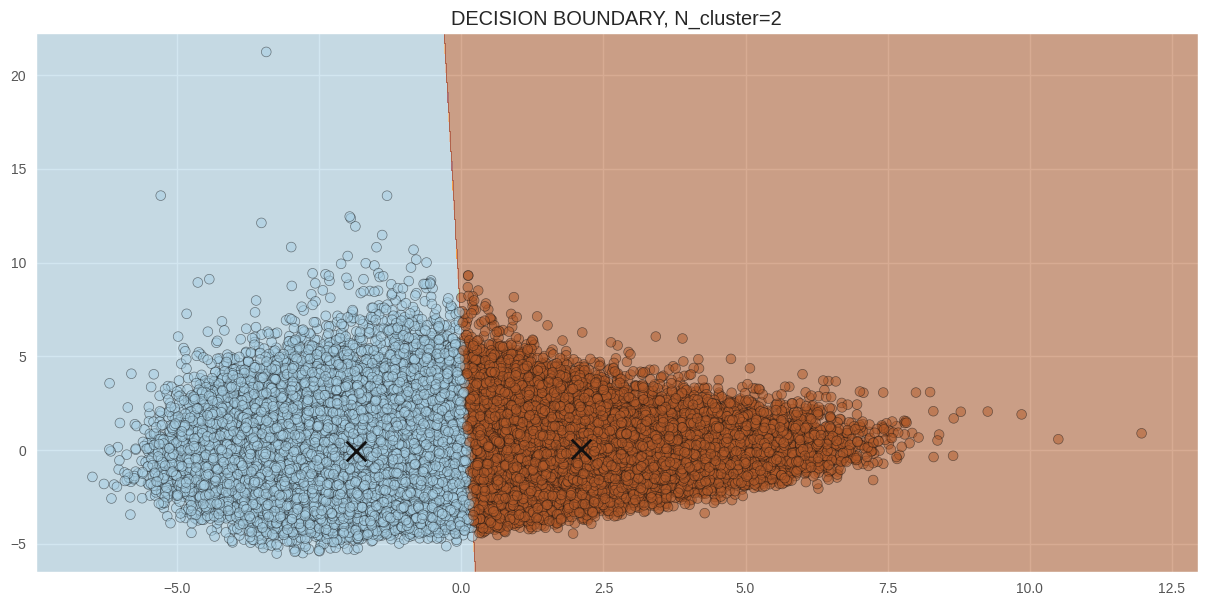

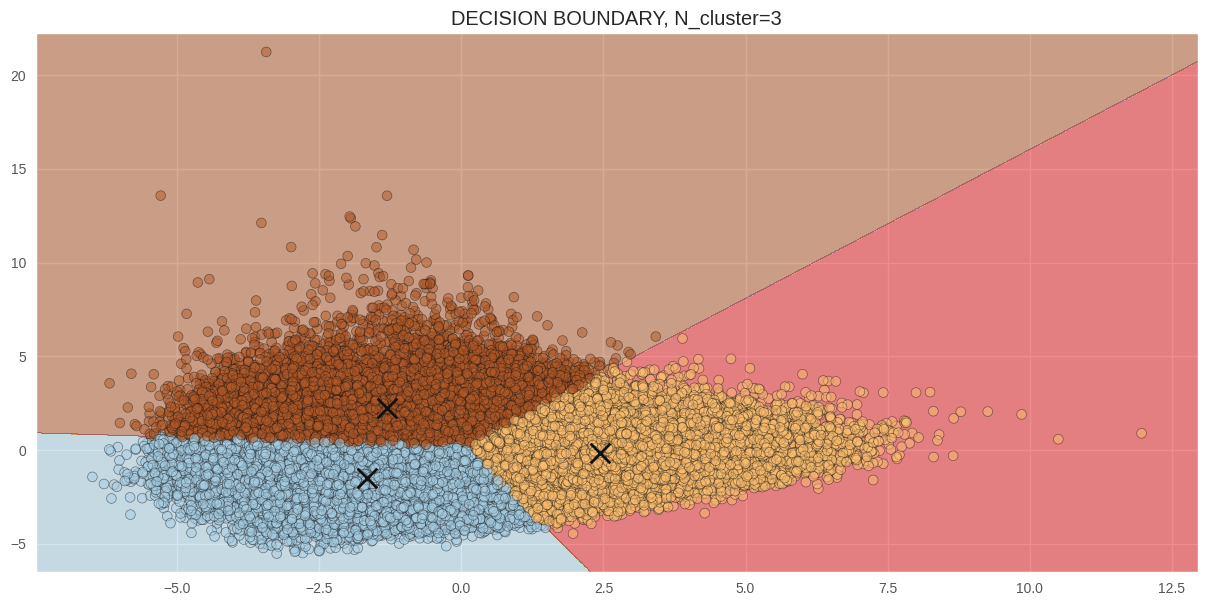

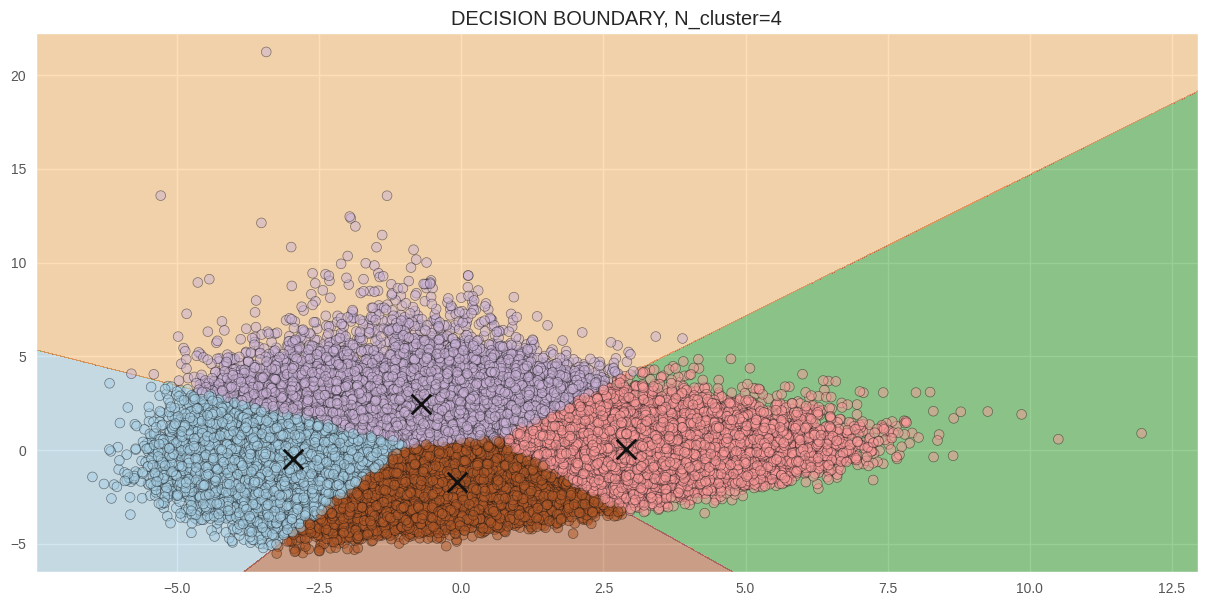

In [113]:
for i in range(2, 5):
  Plot_Decision_Boundary(X, i)

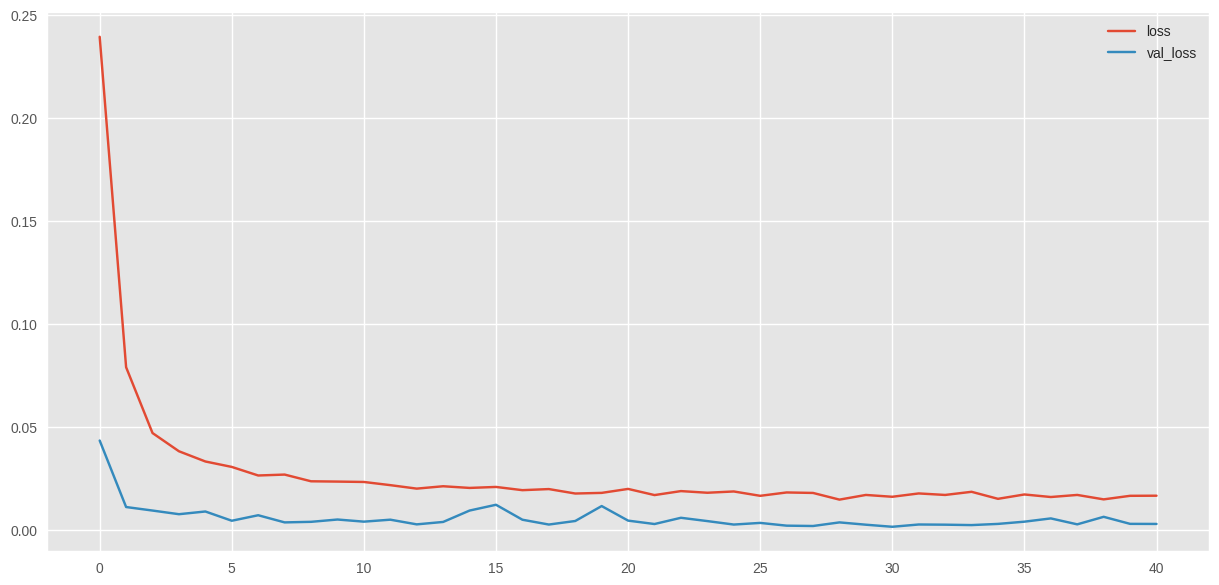

In [87]:
l_p = pd.DataFrame(history_2.history)[["loss", "val_loss"]].plot(figsize=(15, 7))

plt.show()

# Eddy